# Learning to make a market with mbt_gym and Stable Baselines 3

### Import external modules

In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecMonitor

### Add mbt-gym to path

In [2]:
import sys
sys.path.append("../")

In [3]:
from mbt_gym.agents.BaselineAgents import CarteaJaimungalMmAgent
from mbt_gym.gym.helpers.generate_trajectory import generate_trajectory
from mbt_gym.gym.StableBaselinesTradingEnvironment import StableBaselinesTradingEnvironment
from mbt_gym.gym.TradingEnvironment import TradingEnvironment
from mbt_gym.gym.wrappers import *
from mbt_gym.rewards.RewardFunctions import PnL, CjMmCriterion
from mbt_gym.stochastic_processes.midprice_models import BrownianMotionMidpriceModel
from mbt_gym.stochastic_processes.arrival_models import PoissonArrivalModel
from mbt_gym.stochastic_processes.fill_probability_models import ExponentialFillFunction
from mbt_gym.gym.ModelDynamics import LimitOrderModelDynamics

### Create market making environment

In [4]:
terminal_time = 1.0
arrival_rate = 10.0
n_steps = int(10 * terminal_time * arrival_rate)
phi = 0.5
alpha = 0.001

In [5]:
def get_cj_env(num_trajectories:int = 1):
    fill_exponent = 1
    sigma = 0.1
    initial_inventory = (-4,5)
    initial_price = 100
    step_size = 1/n_steps
    timestamps = np.linspace(0, terminal_time, n_steps + 1)
    midprice_model = BrownianMotionMidpriceModel(volatility=sigma, step_size=1/n_steps,
                                                 num_trajectories=num_trajectories)
    arrival_model = PoissonArrivalModel(intensity=np.array([arrival_rate, arrival_rate]), 
                                        step_size=1/n_steps, 
                                        num_trajectories=num_trajectories)
    fill_probability_model = ExponentialFillFunction(fill_exponent=fill_exponent, 
                                                     step_size=1/n_steps,
                                                     num_trajectories=num_trajectories)
    LOtrader = LimitOrderModelDynamics(midprice_model = midprice_model, arrival_model = arrival_model, 
                                fill_probability_model = fill_probability_model,
                                num_trajectories = num_trajectories)
    reward_function = CjMmCriterion(per_step_inventory_aversion = phi, terminal_inventory_aversion = alpha)
    env_params = dict(terminal_time=terminal_time, 
                      n_steps=n_steps,
                      initial_inventory = initial_inventory,
                      model_dynamics = LOtrader,
                      max_inventory=n_steps,
                      normalise_action_space = False,
                      normalise_observation_space = False,
                      reward_function = reward_function,
                      num_trajectories=num_trajectories)
    return TradingEnvironment(**env_params)

In [6]:
num_trajectories = 1000
cj_env = ReduceStateSizeWrapper(get_cj_env(num_trajectories))
sb_cj_env = StableBaselinesTradingEnvironment(trading_env=cj_env)

In [7]:
# Monitor sb_env
sb_cj_env = VecMonitor(sb_cj_env)
# Add directory for tensorboard logging and best model
tensorboard_logdir = "./tensorboard/PPO-learning-CJ/"
best_model_path = "./SB_models/PPO-best-CJ"

### Define PPO policy

In [8]:
policy_kwargs = dict(net_arch=[dict(pi=[256, 256], vf=[256, 256])])
PPO_params = {"policy":'MlpPolicy', "env": sb_cj_env, "verbose":1, 
              "policy_kwargs":policy_kwargs, 
              "tensorboard_log":tensorboard_logdir,
              "n_epochs":3,
              "batch_size": int(n_steps * num_trajectories / 10), 
              "n_steps": int(n_steps)}
callback_params = dict(eval_env=sb_cj_env, n_eval_episodes = 2048, #200 before  (n_eval_episodes)
                       best_model_save_path = best_model_path, 
                       deterministic=True)

callback = EvalCallback(**callback_params)
cj_model = PPO(**PPO_params, device="cpu")

Using cpu device


In [9]:
cj_model.learn(
    total_timesteps = 10_000_000,
    callback = callback
    # total_timesteps = 100_000
)  # Increase number of training timesteps according to computing resources

Logging to ./tensorboard/PPO-learning-CJ/PPO_9
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 100       |
|    ep_rew_mean     | -4.736301 |
| time/              |           |
|    fps             | 274659    |
|    iterations      | 1         |
|    time_elapsed    | 0         |
|    total_timesteps | 100000    |
----------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -3.8415134 |
| time/                   |            |
|    fps                  | 69406      |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 200000     |
| train/                  |            |
|    approx_kl            | 0.00214736 |
|    clip_fraction        | 0.00903    |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.84      |
|    explained_variance   | 0

## Comparing the learnt policy to the optimal policy

In [80]:
# Collect SB Agent actions
from mbt_gym.agents.SbAgent import SbAgent

cj_ppo_agent = SbAgent(cj_model)

inventories = np.arange(-3,4,1)
cj_ppo_bid_actions = []
cj_ppo_ask_actions = []
for inventory in inventories:
    bid_action, ask_action = cj_ppo_agent.get_action(np.array([[inventory,0.5]])).reshape(-1)
    cj_ppo_bid_actions.append(bid_action)
    cj_ppo_ask_actions.append(ask_action)    

In [139]:
# Get the Cartea Jaimungal action
cj_agent = CarteaJaimungalMmAgent(env=get_cj_env())

cj_bid_actions = []
cj_ask_actions = []
for inventory in inventories:
    bid_action, ask_action = cj_agent.get_action(np.array([[0,inventory,0.5]])).reshape(-1)
    cj_bid_actions.append(bid_action)
    cj_ask_actions.append(ask_action)

State shape: (1, 3)
State sample: [ 0.  -3.   0.5]
State shape: (1, 3)
State sample: [ 0.  -2.   0.5]
State shape: (1, 3)
State sample: [ 0.  -1.   0.5]
State shape: (1, 3)
State sample: [0.  0.  0.5]
State shape: (1, 3)
State sample: [0.  1.  0.5]
State shape: (1, 3)
State sample: [0.  2.  0.5]
State shape: (1, 3)
State sample: [0.  3.  0.5]


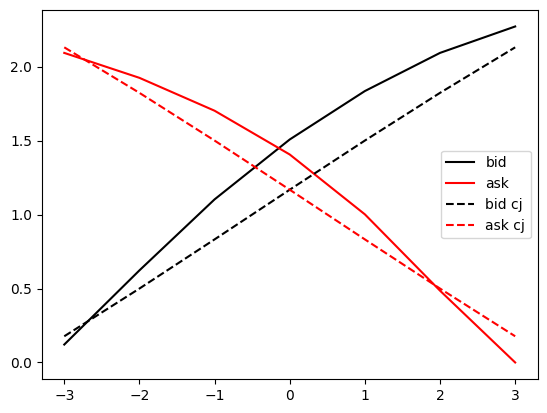

In [140]:
plt.plot(inventories, cj_ppo_bid_actions, label = "bid", color = "k")
plt.plot(inventories, cj_ppo_ask_actions, label = "ask", color = "r")

plt.plot(inventories, cj_bid_actions, label = "bid cj", color = "k", linestyle = "--")
plt.plot(inventories, cj_ask_actions, label = "ask cj", color = "r", linestyle = "--")

plt.legend()

## Backtest agents

In [13]:
%load_ext autoreload
%autoreload 2

In [142]:
# %% [code]
from mbt_gym.gym.backtesting import get_sharpe_ratio, get_maximum_drawdown

# Evaluate performance using a single trajectory (backtesting functions assume a single trajectory)
sharpe = get_sharpe_ratio(cj_agent.env, cj_agent)
max_dd = get_maximum_drawdown(cj_agent.env, cj_agent)

print(f"Sharpe Ratio: {sharpe:.4f}")
print(f"Maximum Drawdown: {max_dd:.4f}")

Sharpe Ratio: 2.8478
Maximum Drawdown: -0.0121


In [98]:
num_trajectories = 1
cj_env = get_cj_env(num_trajectories)
# cj_env = ReduceStateSizeWrapper(cj_env)
sb_cj_env = StableBaselinesTradingEnvironment(trading_env=cj_env)

# Monitor sb_env
sb_cj_env = VecMonitor(sb_cj_env)

# Add directory for tensorboard logging and best model
tensorboard_logdir = "./tensorboard/PPO-learning-CJ/"
best_model_path = "./SB_models/PPO-best-CJ"
policy_kwargs = dict(net_arch=[dict(pi=[256, 256], vf=[256, 256])])
PPO_params = {"policy":'MlpPolicy', "env": sb_cj_env, "verbose":1, 
              "policy_kwargs":policy_kwargs, 
              "tensorboard_log":tensorboard_logdir,
              "n_epochs":3,
              "batch_size": int(n_steps * num_trajectories / 10), 
              "n_steps": int(n_steps)}
callback_params = dict(eval_env=sb_cj_env, n_eval_episodes = 2048, #200 before  (n_eval_episodes)
                       best_model_save_path = best_model_path, 
                       deterministic=True)

callback = EvalCallback(**callback_params)

eval_cj_model = PPO(**PPO_params, device="cpu")
dummy_eval_cj_model = PPO(**PPO_params, device="cpu")

Using cpu device
Using cpu device


In [99]:
# Copy weights to eval model

import torch

# Get the state dict from the pretrained model.
params = cj_model.get_parameters()

# Extract the old weights from the nested "policy" dictionary.
old_policy_weight = params["policy"]["mlp_extractor.policy_net.0.weight"]  # shape: [256, 2]
old_value_weight = params["policy"]["mlp_extractor.value_net.0.weight"]    # shape: [256, 2]

# Define the new input dimension.
new_input_dim = 4
old_input_dim = old_policy_weight.shape[1]  # should be 2

# Create new weight matrices with the new input dimension.
new_policy_weight = torch.zeros(old_policy_weight.shape[0], new_input_dim)
new_value_weight = torch.zeros(old_value_weight.shape[0], new_input_dim)

# Copy the pretrained weights for the first old_input_dim features.
new_policy_weight[:, :old_input_dim] = old_policy_weight
new_value_weight[:, :old_input_dim] = old_value_weight

# Replace the corresponding entries in the state dict.
params["policy"]["mlp_extractor.policy_net.0.weight"] = new_policy_weight
params["policy"]["mlp_extractor.value_net.0.weight"] = new_value_weight

# Now set the parameters in the evaluation model.
eval_cj_model.set_parameters(params, exact_match=False)

In [101]:
# %% [code]
from mbt_gym.gym.backtesting import get_sharpe_ratio, get_maximum_drawdown

from copy import copy

eval_cj_ppo_agent = SbAgent(eval_cj_model)
eval_cj_ppo_agent.env = cj_env
eval_cj_ppo_agent.observation_space = cj_env.observation_space

dummy_eval_cj_ppo_agent = SbAgent(dummy_eval_cj_model)
dummy_eval_cj_ppo_agent.env = cj_env
dummy_eval_cj_ppo_agent.observation_space = cj_env.observation_space

sharpe = get_sharpe_ratio(eval_cj_ppo_agent.env, eval_cj_ppo_agent)  # or model, depending on your agent instance
max_dd = get_maximum_drawdown(eval_cj_ppo_agent.env, eval_cj_ppo_agent)

print(f"Sharpe Ratio: {sharpe:.4f}")
print(f"Maximum Drawdown: {max_dd:.4f}")

Sharpe Ratio: 1.5688
Maximum Drawdown: -0.0119


## Compute sampled metrics

In [102]:
# %% [code]
import numpy as np
from mbt_gym.gym.backtesting import get_sharpe_ratio, get_maximum_drawdown
from tqdm.notebook import tqdm

def compute_sampled_metrics(env, agent, nsamples=100):
    """
    Run nsamples episodes and compute the Sharpe Ratio and Maximum Drawdown for each episode.
    Then print the mean ± standard deviation of each metric.
    
    Parameters:
      env (gym.Env): The trading environment.
      agent (Agent): The agent instance (e.g., SbAgent or any agent with a get_action method).
      nsamples (int): Number of episodes to sample.
    """
    sharpe_values = []
    max_dd_values = []
    
    for i in tqdm(range(nsamples)):
        # Reset the environment to obtain a fresh episode.
        env.reset()
        # Compute metrics for the current episode.
        sharpe = get_sharpe_ratio(env, agent)
        max_dd = get_maximum_drawdown(env, agent)
        sharpe_values.append(sharpe)
        max_dd_values.append(max_dd)
    
    sharpe_mean = np.mean(sharpe_values)
    sharpe_std = np.std(sharpe_values)
    max_dd_mean = np.mean(max_dd_values)
    max_dd_std = np.std(max_dd_values)
    
    print(f"Over {nsamples} samples:")
    print(f"Sharpe Ratio: {sharpe_mean:.4f} ± {sharpe_std:.4f}")
    print(f"Maximum Drawdown: {max_dd_mean:.4f} ± {max_dd_std:.4f}")
    
    return sharpe_mean, sharpe_std, max_dd_mean, max_dd_std

In [108]:
# Example usage:
_ = compute_sampled_metrics(eval_cj_ppo_agent.env, eval_cj_ppo_agent, nsamples=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Over 50 samples:
Sharpe Ratio: 0.3221 ± 1.4433
Maximum Drawdown: -0.0422 ± 0.1337


In [110]:
# Example usage:
_ = compute_sampled_metrics(
    dummy_eval_cj_ppo_agent.env, dummy_eval_cj_ppo_agent, nsamples=50
)

  0%|          | 0/50 [00:00<?, ?it/s]

Over 50 samples:
Sharpe Ratio: 0.3344 ± 1.1042
Maximum Drawdown: -160.0165 ± 1095.4590


# Avellaneda-Stoikov model

## Create market making environment

In [ ]:

def get_as_env(num_trajectories:int = 1, seed=None):
    initial_price = 100
    terminal_time = 1.0
    sigma = 2.0
    n_steps = 200
    initial_inventory = 0
    arrival_rate = 140
    fill_exponent = 1.5
    midprice_model = BrownianMotionMidpriceModel(initial_price = initial_price, 
                                                 volatility=sigma, step_size=1/n_steps,
                                                 terminal_time = terminal_time,
                                                 num_trajectories=num_trajectories)
    arrival_model = PoissonArrivalModel(intensity=np.array([arrival_rate, arrival_rate]), 
                                        step_size=1/n_steps, 
                                        num_trajectories=num_trajectories)
    fill_probability_model = ExponentialFillFunction(fill_exponent=fill_exponent, 
                                                     step_size=1/n_steps,
                                                     num_trajectories=num_trajectories)
    LOtrader = LimitOrderModelDynamics(midprice_model = midprice_model, arrival_model = arrival_model, 
                                fill_probability_model = fill_probability_model,
                                num_trajectories = num_trajectories)
    env_params = dict(terminal_time=terminal_time, 
                      n_steps=n_steps,
                      seed = seed,
                      initial_inventory = initial_inventory,
                      model_dynamics = LOtrader,
                      max_inventory=n_steps,
                      normalise_action_space = False,
                      normalise_observation_space = False,
                      num_trajectories=num_trajectories)
    return TradingEnvironment(**env_params)

In [ ]:
num_trajectories = 1000
as_env = ReduceStateSizeWrapper(get_as_env(num_trajectories))
sb_as_env = StableBaselinesTradingEnvironment(trading_env=as_env)

# Monitor sb_env
sb_as_env = VecMonitor(sb_as_env)
# Add directory for tensorboard logging and best model
tensorboard_logdir = "./tensorboard/PPO-learning-AS/"
best_model_path = "./SB_models/PPO-best-AS"

## Define PPO policy

In [ ]:
policy_kwargs = dict(net_arch=[dict(pi=[256, 256], vf=[256, 256])])
PPO_params = {"policy":'MlpPolicy', "env": sb_as_env, "verbose":1, 
              "policy_kwargs":policy_kwargs, 
              "tensorboard_log":tensorboard_logdir,
              "n_epochs":3,
              "batch_size": int(n_steps * num_trajectories / 10), 
              "n_steps": int(n_steps)}
callback_params = dict(eval_env=sb_as_env, n_eval_episodes = 2048, #200 before  (n_eval_episodes)
                       best_model_save_path = best_model_path, 
                       deterministic=True)

callback = EvalCallback(**callback_params)
as_model = PPO(**PPO_params, device="cpu")

Using cpu device


In [ ]:
as_model.learn(total_timesteps = 10_000_000)  # Increase number of training timesteps according to computing resources

Logging to ./tensorboard/PPO-learning-AS/PPO_4


-------------------------------
| time/              |        |
|    fps             | 283698 |
|    iterations      | 1      |
|    time_elapsed    | 0      |
|    total_timesteps | 100000 |
-------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 200          |
|    ep_rew_mean          | 29.76499     |
| time/                   |              |
|    fps                  | 63343        |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 200000       |
| train/                  |              |
|    approx_kl            | 0.0016583328 |
|    clip_fraction        | 0.00488      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0.0277       |
|    learning_rate        | 0.0003       |
|    loss                 | 3.16         |
|    n_updates            | 3            |
| 

## Comparing the learnt policy to the optimal policy

In [ ]:
from mbt_gym.agents.SbAgent import SbAgent

as_ppo_agent = SbAgent(as_model)

inventories = np.arange(-3,4,1)
as_model_bid_actions = []
as_model_ask_actions = []
for inventory in inventories:
    bid_action, ask_action = as_ppo_agent.get_action(np.array([[inventory,0.5]])).reshape(-1)
    as_model_bid_actions.append(bid_action)
    as_model_ask_actions.append(ask_action) 

In [ ]:
from mbt_gym.agents.BaselineAgents import AvellanedaStoikovAgent
# Get the AS action

as_env = get_as_env()
as_agent = AvellanedaStoikovAgent(risk_aversion=0.1, env=as_env)

as_baseline_bid_actions = []
as_baseline_ask_actions = []
for inventory in inventories:
    bid_action, ask_action = as_agent.get_action(np.array([[0,inventory,0.5]])).reshape(-1)
    as_baseline_bid_actions.append(bid_action)
    as_baseline_ask_actions.append(ask_action)

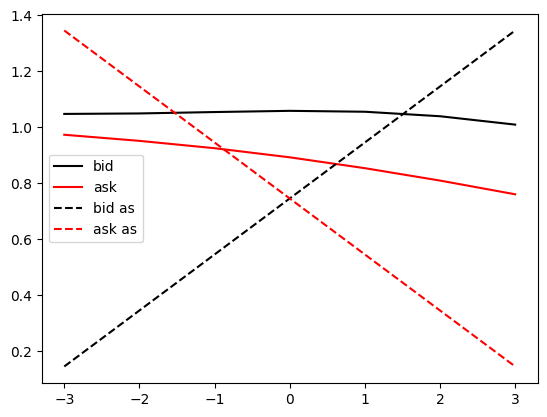

In [ ]:
plt.plot(inventories, as_model_bid_actions, label = "bid", color = "k")
plt.plot(inventories, as_model_ask_actions, label = "ask", color = "r")

plt.plot(inventories, as_baseline_bid_actions, label = "bid as", color = "k", linestyle = "--")
plt.plot(inventories, as_baseline_ask_actions, label = "ask as", color = "r", linestyle = "--")

plt.legend()

## Backtest agents

In [ ]:
# %% [code]
from mbt_gym.gym.backtesting import get_sharpe_ratio, get_maximum_drawdown

# Evaluate performance using a single trajectory (backtesting functions assume a single trajectory)
sharpe = get_sharpe_ratio(as_agent.env, as_agent)
max_dd = get_maximum_drawdown(as_agent.env, as_agent)

print(f"Sharpe Ratio: {sharpe:.4f}")
print(f"Maximum Drawdown: {max_dd:.4f}")

Sharpe Ratio: 4.0675
Maximum Drawdown: -0.0398


In [ ]:
num_trajectories = 1
as_env = get_as_env(num_trajectories)
# as_env = ReduceStateSizeWrapper(as_env)
sb_as_env = StableBaselinesTradingEnvironment(trading_env=as_env)

# Monitor sb_env
sb_as_env = VecMonitor(sb_as_env)

# Add directory for tensorboard logging and best model
tensorboard_logdir = "./tensorboard/PPO-learning-as/"
best_model_path = "./SB_models/PPO-best-as"
policy_kwargs = dict(net_arch=[dict(pi=[256, 256], vf=[256, 256])])
PPO_params = {"policy":'MlpPolicy', "env": sb_as_env, "verbose":1, 
              "policy_kwargs":policy_kwargs, 
              "tensorboard_log":tensorboard_logdir,
              "n_epochs":3,
              "batch_size": int(n_steps * num_trajectories / 10), 
              "n_steps": int(n_steps)}
callback_params = dict(eval_env=sb_as_env, n_eval_episodes = 2048, #200 before  (n_eval_episodes)
                       best_model_save_path = best_model_path, 
                       deterministic=True)

callback = EvalCallback(**callback_params)

eval_as_model = PPO(**PPO_params, device="cpu")
dummy_eval_as_model = PPO(**PPO_params, device="cpu")

Using cpu device
Using cpu device


In [ ]:
# Copy weights to eval model

import torch

# Get the state dict from the pretrained model.
params = as_model.get_parameters()

# Extract the old weights from the nested "policy" dictionary.
old_policy_weight = params["policy"]["mlp_extractor.policy_net.0.weight"]  # shape: [256, 2]
old_value_weight = params["policy"]["mlp_extractor.value_net.0.weight"]    # shape: [256, 2]

# Define the new input dimension.
new_input_dim = 4
old_input_dim = old_policy_weight.shape[1]  # should be 2

# Create new weight matrices with the new input dimension.
new_policy_weight = torch.zeros(old_policy_weight.shape[0], new_input_dim)
new_value_weight = torch.zeros(old_value_weight.shape[0], new_input_dim)

# Copy the pretrained weights for the first old_input_dim features.
new_policy_weight[:, :old_input_dim] = old_policy_weight
new_value_weight[:, :old_input_dim] = old_value_weight

# Replace the corresponding entries in the state dict.
params["policy"]["mlp_extractor.policy_net.0.weight"] = new_policy_weight
params["policy"]["mlp_extractor.value_net.0.weight"] = new_value_weight

# Now set the parameters in the evaluation model.
eval_as_model.set_parameters(params, exact_match=False)

In [ ]:
# %% [code]
from mbt_gym.gym.backtesting import get_sharpe_ratio, get_maximum_drawdown

from copy import copy

eval_as_ppo_agent = SbAgent(eval_as_model)
eval_as_ppo_agent.env = as_env
eval_as_ppo_agent.observation_space = as_env.observation_space

dummy_eval_as_ppo_agent = SbAgent(dummy_eval_as_model)
dummy_eval_as_ppo_agent.env = as_env
dummy_eval_as_ppo_agent.observation_space = as_env.observation_space

sharpe = get_sharpe_ratio(eval_as_ppo_agent.env, eval_as_ppo_agent)  # or model, depending on your agent instance
max_dd = get_maximum_drawdown(eval_as_ppo_agent.env, eval_as_ppo_agent)

print(f"Sharpe Ratio: {sharpe:.4f}")
print(f"Maximum Drawdown: {max_dd:.4f}")

Sharpe Ratio: 2.9564
Maximum Drawdown: -5.0638


## Compute sampled metrics

In [ ]:
_ = compute_sampled_metrics(as_agent.env, as_agent, nsamples=10)

  0%|          | 0/10 [00:00<?, ?it/s]

/home/admin/mbt_gym/notebooks/../mbt_gym/agents/BaselineAgents.py:67: UserWarning: Avellaneda-Stoikov agent is quoting a negative spread
  warnings.warn("Avellaneda-Stoikov agent is quoting a negative spread")


Over 10 samples:
Sharpe Ratio: 3.7257 ± 0.2560
Maximum Drawdown: -0.1397 ± 0.0963


In [ ]:
# Example usage:
_ = compute_sampled_metrics(
    eval_as_ppo_agent.env, eval_as_ppo_agent, nsamples=50
)

  0%|          | 0/50 [00:00<?, ?it/s]

/home/admin/mbt_gym/notebooks/../mbt_gym/gym/backtesting.py:26: UserWarning: Warning: Mean Return % is negative. Sharpe Ratio may not be appropriate.
  warnings.warn("Warning: Mean Return % is negative. Sharpe Ratio may not be appropriate.")


Over 50 samples:
Sharpe Ratio: 1.7911 ± 1.3013
Maximum Drawdown: -199.4602 ± 936.5916


In [ ]:
# Example usage:
_ = compute_sampled_metrics(
    dummy_eval_as_ppo_agent.env, dummy_eval_as_ppo_agent, nsamples=50
)

  0%|          | 0/50 [00:00<?, ?it/s]

Over 50 samples:
Sharpe Ratio: 0.2042 ± 1.0491
Maximum Drawdown: -73178.6466 ± 507977.3410
